<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/LIME_IMAGE_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation and download

In [ ]:
!pip -q install lime
!git clone https://github.com/mobarakol/AI_Medical_Imaging.git
%cd AI_Medical_Imaging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Cloning into 'AI_Medical_Imaging'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 88 (delta 37), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (88/88), 6.13 MiB | 7.95 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/AI_Medical_Imaging


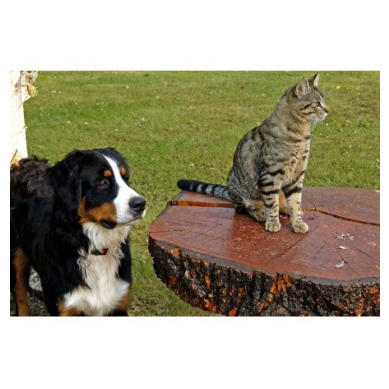

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import requests

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

img_url = 'https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/dogs.png?raw=true'
img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plt.imshow(img)
plt.axis('OFF');

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [ ]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

#Load label texts for ImageNet predictions so we know what model is predicting
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

Load the pretrained model for Resnet50 available in Pytorch.

In [ ]:
model = models.inception_v3(pretrained=True)
model.eval()
img_t = get_input_tensors(img)
logits = model(img_t)

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 104MB/s] 


((0.9359297, 239, 'Bernese_mountain_dog'),
 (0.038447842, 241, 'EntleBucher'),
 (0.023756254, 240, 'Appenzeller'),
 (0.001818174, 238, 'Greater_Swiss_Mountain_dog'),
 (9.113287e-06, 214, 'Gordon_setter'))

LIME in Image Classification

  0%|          | 0/1000 [00:00<?, ?it/s]

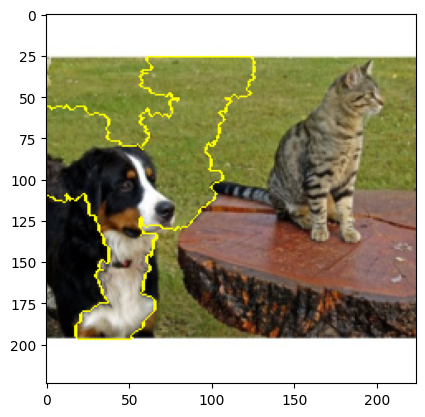

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification fun

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

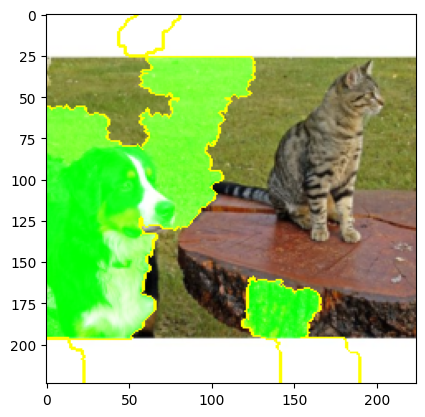

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

# LIME on Brain Tumor Dataset
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Download my trained weights on resnet34:

In [ ]:
import gdown

!mkdir myweights
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

'myweights/best_model.pth.tar'

Data preprocessing as training model

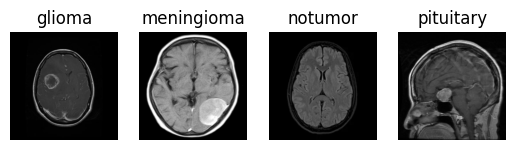

In [ ]:
import torchvision.transforms as transforms

def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()


class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
newsize = (224, 224)
img_glioma = Image.open('/content/AI_Medical_Imaging/braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('/content/AI_Medical_Imaging/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('/content/AI_Medical_Imaging/braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('/content/AI_Medical_Imaging/braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Model Prediction:

In [ ]:
import torch
from torchvision import models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4

def tumor_prediction(img):
    model = models.resnet34()
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    model.load_state_dict(torch.load('/content/AI_Medical_Imaging/myweights/best_model.pth.tar', map_location=device))
    model.eval()
    img = [pill_transf(img)]
    img = torch.stack(tuple(preprocess_transform(i) for i in img), dim=0)
    img = img.to(device)
    logit = model(img)
    predicted_classes = torch.argmax(logit, axis=1).cpu().numpy()
    return predicted_classes

with torch.no_grad():
    predicted_classes = tumor_prediction(img_glioma)
    print('Predicted Class:', class_names[predicted_classes[0]])

Predicted Class: glioma


Applying LIME:

  0%|          | 0/1500 [00:00<?, ?it/s]

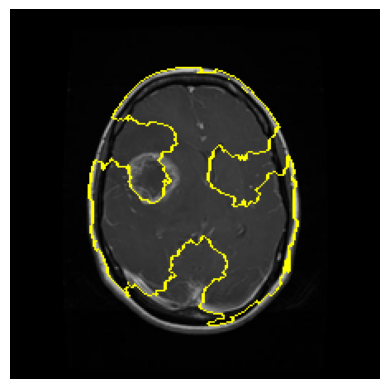

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import torch
import torchvision
from torchvision import models
import matplotlib.pyplot as plt


def load_model():
    model = models.resnet34(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    model.load_state_dict(torch.load('/content/AI_Medical_Imaging/myweights/best_model.pth.tar', map_location=device))
    model.eval()
    return model


device = 'cuda' if torch.cuda.is_available() else 'cpu'
img = img_glioma
model = load_model()

#Write your code below to apply LIME